In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Iris dataset

In [2]:
# ファイル読み込み
in_file = '../data/iris.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep=',')
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.8,2.6,4.0,1.2,Iris-versicolor
1,5.8,4.0,1.2,0.2,Iris-setosa
2,6.3,2.5,4.9,1.5,Iris-versicolor
3,5.5,3.5,1.3,0.2,Iris-setosa
4,6.0,3.0,4.8,1.8,Iris-virginica


In [3]:
# データセットの作成
target = 'Iris-virginica'
df_nontarget = df[df['class']!=target]
X_train = df_nontarget.drop('class', axis=1)
y_train = (df_nontarget['class']!=target).astype(np.int32)
X_test = df.drop('class', axis=1)
y_test = (df['class']==target).astype(np.int32)

best bandwidth: 0.20691380811147897
best bandwidth: 0.20691380811147897
best bandwidth: 0.20691380811147897


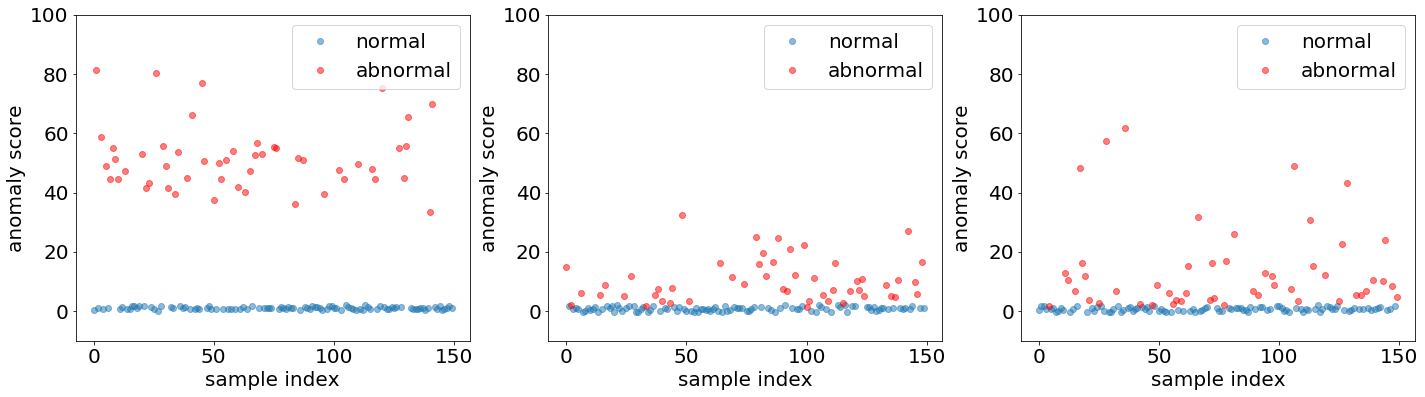

In [4]:
# カーネル密度推定の実行
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)

plt.figure(figsize=(24, 6))
for i, target in enumerate(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']):
    # 異常度計算
    target_col = 'class'
    df_nontarget = df[df[target_col]!=target]
    X_train = df_nontarget.drop(target_col, axis=1)
    y_train = (df_nontarget[target_col]!=target).astype(np.int32)
    X_test = df.drop(target_col, axis=1)
    y_test = (df[target_col]==target).astype(np.int32)
    grid.fit(X_train)
    print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    kde = grid.best_estimator_
    a = -kde.score_samples(X_test)
    
    # 描画
    plt.rcParams.update({'font.size': 20})
    plt.subplot(1, 3, i+1)
    plt.ylim(-10, 100)
    plt.locator_params(axis='y',nbins=6)
    plt.xlabel('sample index')
    plt.ylabel('anomaly score')
    plt.plot(np.where(y_test==0)[0], a[np.where(y_test==0)[0]], 'o', alpha=.5, label='normal')
    plt.plot(np.where(y_test!=0)[0], a[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.5, label='abnormal')
    plt.legend(loc=1)

plt.show()

# Winequality

In [5]:
# ファイル読み込み
in_file = '../data/winequality-white.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep=';').sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2117,7.7,0.26,0.32,1.2,0.040,26.0,117.0,0.99300,3.21,0.56,10.8,5
4558,5.9,0.21,0.23,7.9,0.033,22.0,130.0,0.99440,3.38,0.59,10.9,6
1052,7.6,0.29,0.42,1.3,0.035,18.0,86.0,0.99080,2.99,0.39,11.3,5
3052,5.6,0.20,0.66,10.2,0.043,78.0,175.0,0.99450,2.98,0.43,10.4,7
3743,7.0,0.15,0.28,14.7,0.051,29.0,149.0,0.99792,2.96,0.39,9.0,7


In [6]:
# データセットの作成
target = 4
target_col = 'quality'
df_nontarget = df[df[target_col]>target]
X_train = df_nontarget.drop(target_col, axis=1)
y_train = (df_nontarget[target_col]<=target).astype(np.int32)
X_test = df.drop(target_col, axis=1)
y_test = (df[target_col]==target).astype(np.int32)

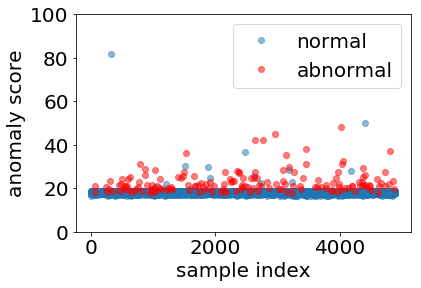

In [7]:
# カーネル密度推定の実行
"""
params = {'bandwidth': np.logspace(-1, 1, 10)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X_train)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
kde = grid.best_estimator_
"""
kde = KernelDensity()
kde.fit(X_train)
a = -kde.score_samples(X_test)

# 描画
plt.rcParams.update({'font.size': 20})
plt.ylim(0, 100)
plt.locator_params(axis='y',nbins=6)
plt.xlabel('sample index')
plt.ylabel('anomaly score')
plt.plot(np.where(y_test==0)[0], a[np.where(y_test==0)[0]], 'o', alpha=.5, label='normal')
plt.plot(np.where(y_test!=0)[0], a[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.5, label='abnormal')
plt.legend(loc=1)
plt.show()

In [8]:
# 性能分岐点の計算 
y_test.reset_index(drop=True, inplace=True) # インデックスリセット
idx = a.argsort()[::-1] # 降順のインデックス計算
n_total = len(y_test)
n_anom = sum(y_test)
n_norm = n_total - n_anom
coverage = [sum(y_test[idx][:i]) / n_anom for i in range(n_total)] # 異常標本精度
detection = [(n_total - i - sum(y_test[idx][i:])) / n_norm for i in range(n_total)] # 正常標本精度

thresh = 0

for i, (c, d) in enumerate(zip(coverage, detection)):
    if c >= d:
        thresh = i
        break
break_even_point = a[idx][thresh]
print('閾値', break_even_point)
print('性能分岐点', c, d)

閾値 18.561315563143292
性能分岐点 0.9141104294478528 0.9140443505807814


# Urbann Land Cover

In [9]:
# ファイル読み込み
in_file_train = '../data/urban_land_cover_training.csv'
in_file_test = '../data/urban_land_cover_testing.csv'
df_train = pd.read_csv(in_file_train, header=0, index_col=None, sep=',')
df_test = pd.read_csv(in_file_test, header=0, index_col=None, sep=',')
df = pd.concat([df_train, df_test], axis=0)
df.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


In [10]:
# データセットの作成
target = 'pool '
target_col = 'class'

# インデックスのリセット
df.reset_index(drop=True)

df_nontarget = df[df[target_col]!=target]  # 正常データサンプルを抽出
X_train = df_nontarget.drop(target_col, axis=1)  # 正常データのクラスラベルを削除して訓練データとする
y_train = (df_nontarget[target_col]==target).astype(np.int32)  # 正常データのラベル
X_test = df.drop(target_col, axis=1)  # 異常データを含む評価用データセット作成
y_test = (df[target_col]==target).astype(np.int32)  # 異常ラベル作成

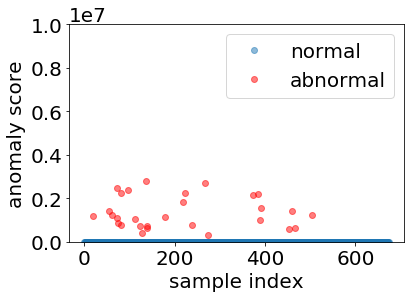

In [11]:
# カーネル密度推定の実行
"""
params = {'bandwidth': np.logspace(-1, 1, 10)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X_train)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
kde = grid.best_estimator_
"""
kde = KernelDensity()
kde.fit(X_train)
a = -kde.score_samples(X_test)

# 描画
plt.rcParams.update({'font.size': 20})
plt.ylim(0, 10000000)
plt.locator_params(axis='y',nbins=6)
plt.xlabel('sample index')
plt.ylabel('anomaly score')
plt.plot(np.where(y_test==0)[0], a[np.where(y_test==0)[0]], 'o', alpha=.5, label='normal')
plt.plot(np.where(y_test!=0)[0], a[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.5, label='abnormal')
plt.legend(loc=1)
plt.show()

# Online News Popularity Dataset

In [12]:
# ファイル読み込み
# pd.options.mode.chained_assignment = None
in_file = '../data/OnlineNewsPopularity.csv'
df = pd.read_csv(in_file, header=0, index_col=None, sep='\s*,\s*', engine='python')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [13]:
# データセットの作成
target = 17600  # 上位1000件
target_col = 'shares'

# インデックスのリセット
df.reset_index(drop=True)

df_nontarget = df[df[target_col]<target]  # 正常データサンプルを抽出
X_train = df_nontarget.drop([target_col, 'url'], axis=1)  # 正常データのクラスラベルを削除して訓練データとする
y_train = (df_nontarget[target_col]>=target).astype(np.int32)  # 正常データのラベル
X_test = df.drop([target_col, 'url'], axis=1)  # 異常データを含む評価用データセット作成
y_test = (df[target_col]>=target).astype(np.int32)  # 異常ラベル作成

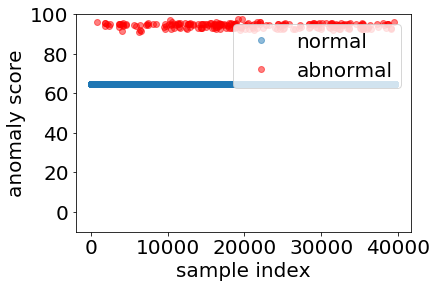

In [14]:
# カーネル密度推定の実行
"""
params = {'bandwidth': np.logspace(-1, 1, 10)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X_train)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
kde = grid.best_estimator_
"""
kde = KernelDensity()
kde.fit(X_train)
a = -kde.score_samples(X_test)

# 描画
plt.rcParams.update({'font.size': 20})
plt.ylim(-10, 100)
plt.locator_params(axis='y',nbins=6)
plt.xlabel('sample index')
plt.ylabel('anomaly score')
plt.plot(np.where(y_test==0)[0], a[np.where(y_test==0)[0]], 'o', alpha=.5, label='normal')
plt.plot(np.where(y_test!=0)[0], a[np.where(y_test!=0)[0]], 'o', color='r',  alpha=.5, label='abnormal')
plt.legend(loc=1)
plt.show()